In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import time
import dask_ml.cluster

In [3]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:41925 Dashboard: http://127.0.0.1:42071/status,Cluster Workers: 4 Cores: 4 Memory: 6.24 GB


In [4]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

14.931962728500366


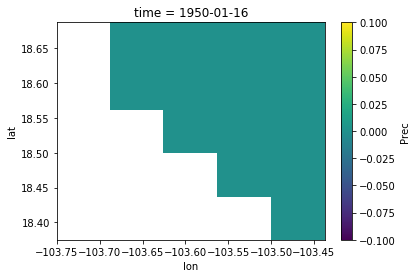

In [329]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
ds2 = ds.isel(lat=slice(60,65), lon=slice(340,345), time=slice(0,20))
#ds2 = ds.isel(time=slice(0,60))
ds2.Prec.isel(time=0).load()
ds2.Prec.isel(time=0).plot()

In [330]:
#Group (x,y) data into list for applying a function
ds3 = ds2.stack(points=['lon','lat'])

In [331]:
#Create the function that stacks each points data. 
def pile(ds):
    temp = [ds.Prec, ds.Tmax, ds.Tmin]
    return da.concatenate(temp,axis=0)

In [334]:
#Peform pile, and put each dask array into two lists: nan and non nan.  Keep track of index ATTEMPT 2
start = time.time()
data_pile = []
data_pile_nan = []
index = []
index_nan = []
count = 0
for p in ds3.points:
    if np.isnan(ds3.Prec.isel(time=0).sel(points=p.values)): #check if nan value
        data_pile_nan.append(pile(ds3.sel(points = p.values)))
        index_nan.append(count)
        count = count +1
    else:
        data_pile.append(pile(ds3.sel(points = p.values)))
        index.append(count)
        count = count + 1
end = time.time()
print(end - start)

2.1254191398620605


In [335]:
#Create a single dask array for use in k-means
data = da.stack(data_pile, axis=0)
data = da.from_array(data,chunks=(100,900)) #Adjust the chunksize to match the shape.  Currently doing by hand
data

dask.array<array, shape=(14, 60), dtype=float32, chunksize=(14, 60)>

In [336]:
#Fit data using K-means
start = time.time()

km = dask_ml.cluster.KMeans(n_clusters=3, init='k-means++', max_iter=10, tol=1)
km.fit(data)

end = time.time()
print(end - start)

185.6692578792572


In [337]:
#Find labels for each non-nan point
classes = km.labels_
classes

dask.array<astype, shape=(14,), dtype=int32, chunksize=(14,)>

In [338]:
#Define label for nan value to be -1
classes_nan = da.ones(len(index_nan),chunks = len(index_nan))*-1

In [339]:
#Combine classes into single dask array: nan values last
class_pile = [classes, classes_nan]
classes_all = da.concatenate(class_pile)

In [340]:
#Create x-array for all the index
index_all = index + index_nan

In [341]:
#Create a data frame of (x,y) points with prediction labels
start = time.time()

temp_array = xr.DataArray(classes_all, dims={'points': ds3.points[index_all]}) #put classes in data array indexed by points
ds4 = ds3
ds4['points'] = ds3.points[index_all]
ds4['classes'] = temp_array
ds4 = ds4.unstack('points')

end = time.time()
print(end - start)

0.025920867919921875


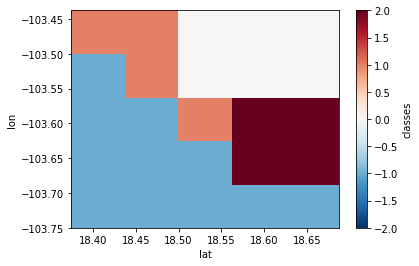

In [343]:
ds4['classes'].plot()

In [321]:
ds4['classes']

<xarray.DataArray 'classes' (lon: 5, lat: 5)>
dask.array<shape=(5, 5), dtype=float64, chunksize=(5, 5)>
Coordinates:
  * lon      (lon) float64 -103.7 -103.7 -103.6 -103.5 -103.5
  * lat      (lat) float64 18.41 18.47 18.53 18.59 18.66

In [322]:
ds2.Prec.mean('time')

<xarray.DataArray 'Prec' (lat: 5, lon: 5)>
dask.array<shape=(5, 5), dtype=float32, chunksize=(5, 5)>
Coordinates:
  * lon      (lon) float64 -103.7 -103.7 -103.6 -103.5 -103.5
  * lat      (lat) float64 18.41 18.47 18.53 18.59 18.66

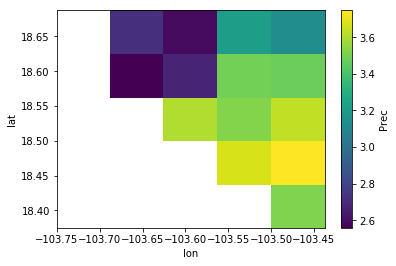

In [301]:
#Compare to mean of Prec, Tmax and Tmin
ds2.Prec.mean('time').plot()

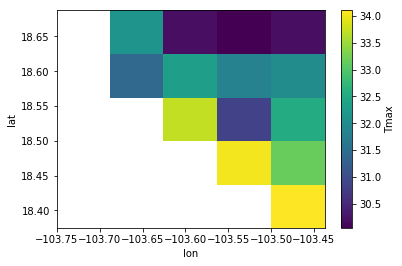

In [263]:
ds2.Tmax.mean('time').plot()

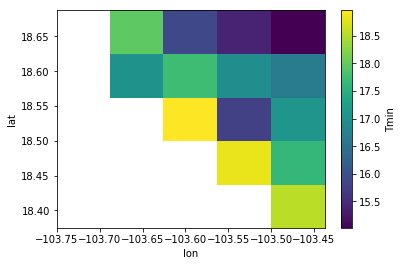

In [264]:
ds2.Tmin.mean('time').plot()

In [6]:
#Here we create a mask for nans.  If value is nan, we set it to 100*max value of ds.
#mask = np.isnan(ds2)   #mask with True at nan
#opmask = np.logical_not(mask)   #oposite mask
#scale = mask.astype(int)*np.max(ds2)*100  #int valued mask with large value at nan, 0 else
#ds3 = scale + np.multiply(opmask.astype(int),ds2.astype(int))

In [7]:
#Here we create a mask for nans.  Set nan value to zero
#mask = np.isnan(ds2)   #mask with True at nan
#opmask = np.logical_not(mask)   #oposite mask
#scale = mask.astype(int)*np.max(ds2)*100  #int valued mask with large value at nan, 0 else
#ds3 = np.multiply(opmask.astype(int),ds2.astype(int))

In [332]:
#Peform pile, and put each dask array into a single list
#start = time.time()
#data_pile = []
#for p in ds4.points:
#    data_pile.append(pile(ds4.sel(points = p.values)))
#end = time.time()
#print(end - start)